In [ ]:
# %% Importações necessárias

import pandas as pd              # Manipulação de DataFrames
import matplotlib.pyplot as plt  # Geração de gráficos
import seaborn as sns
import numpy as np               # Operações matemáticas
from sklearn.cluster import KMeans, DBSCAN  # Algoritmos de clusterização
from sklearn.metrics import silhouette_score, silhouette_samples # Avaliação de clusters
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram # Clusterização hierárquica
import umap  # Redução de dimensionalidade para visualização
import statsmodels.formula.api as sm # Verificar presença de fatores nos clusters 
import plotly.express as px

In [ ]:
# %% Carregando os dados

fatores_df = pd.read_csv(r'C:\Users\maype\Desktop\projetos\Trabalho Prático AM2\data\base_fatores_normalizados.csv', index_col=0)

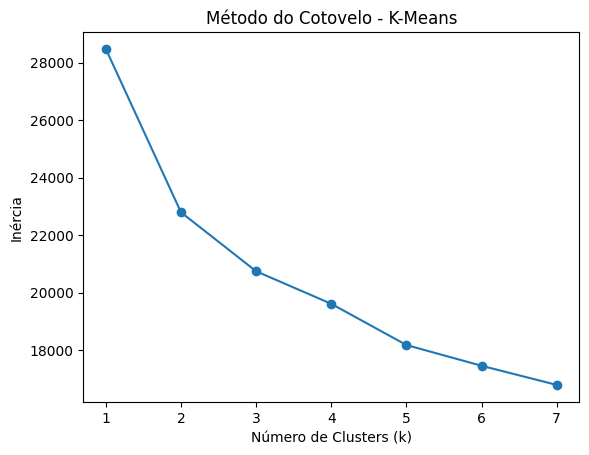

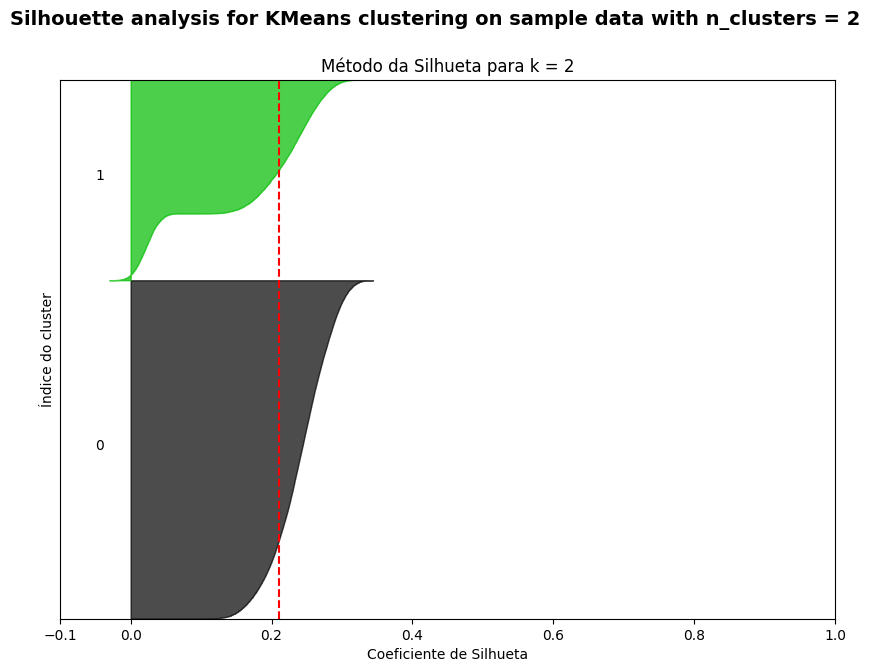

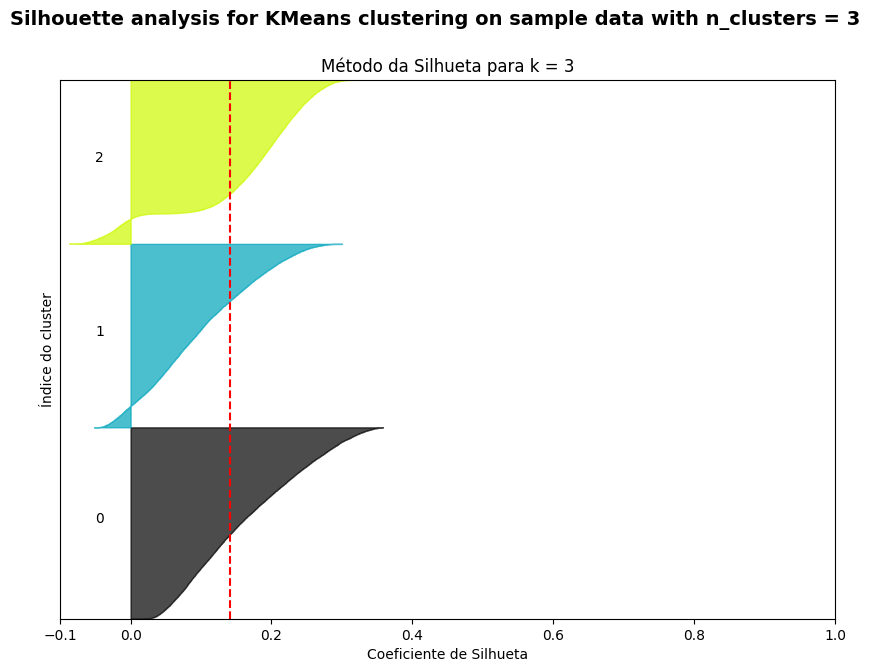

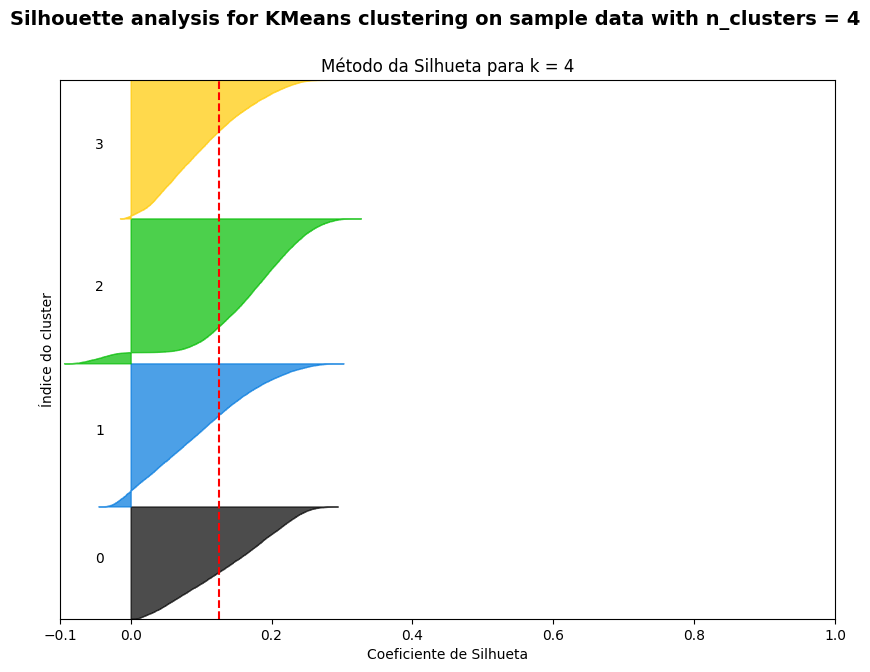

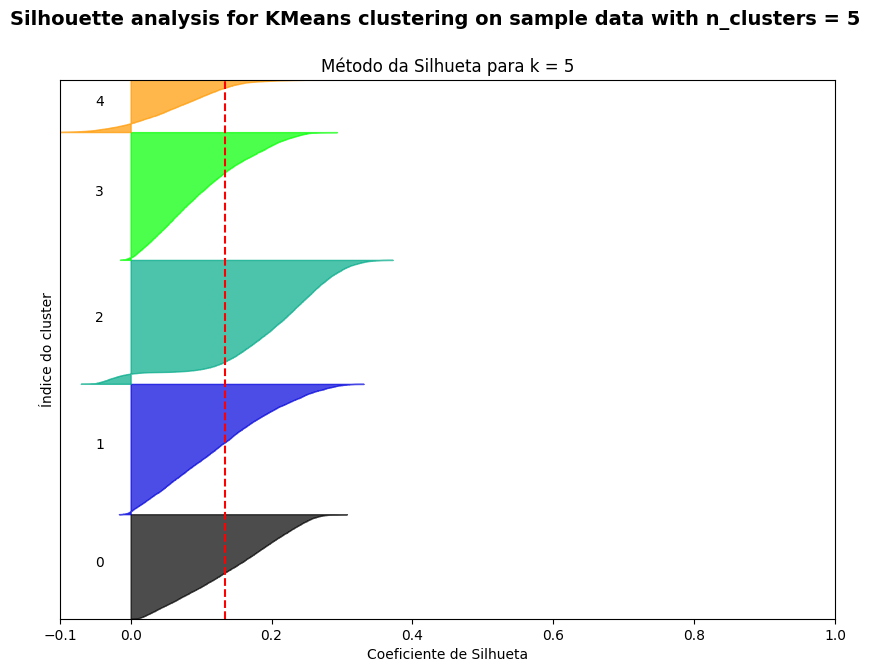

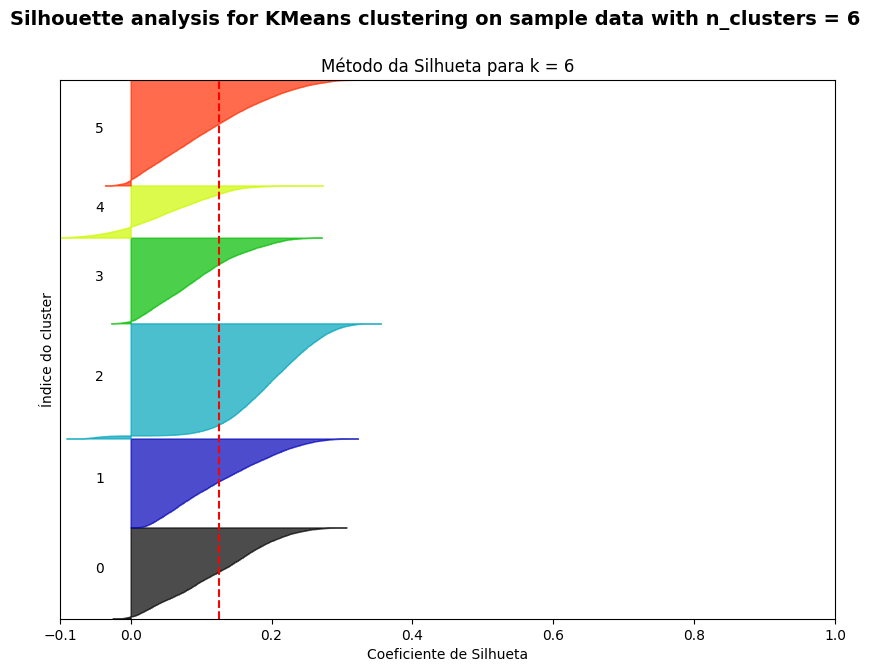

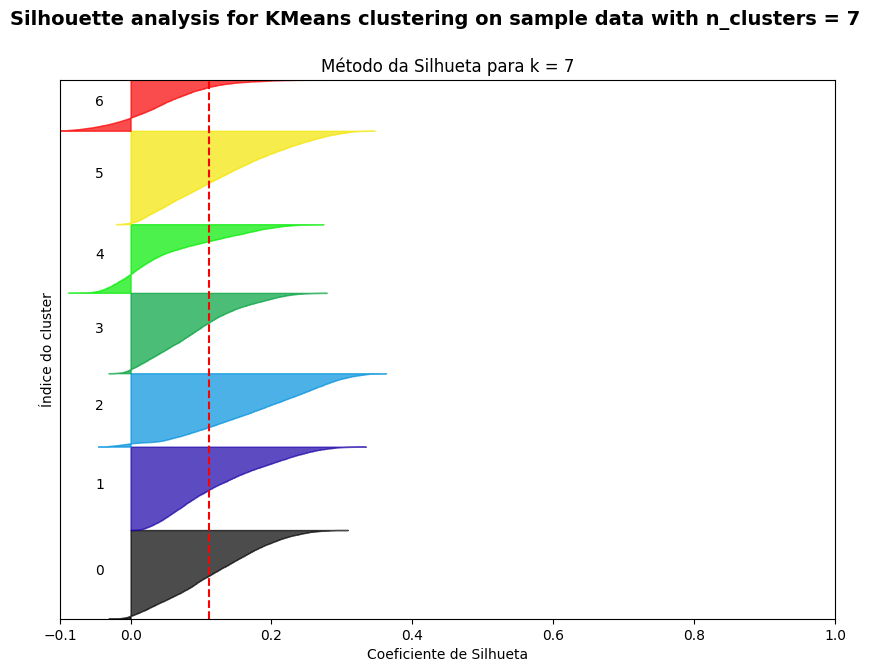

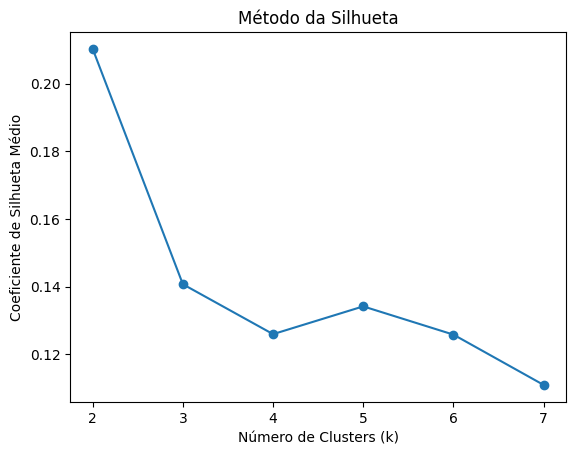

In [ ]:
# %% Método do Cotovelo e Método da Silhuetta para K-Means

def metodo_cotovelo(data, max_clusters=7):
    """
    Determina o número ideal de clusters para K-Means usando o método do cotovelo.

    Args:
        data: DataFrame com os dados para clusterização.
        max_clusters: Número máximo de clusters a serem testados.

    Returns:
        None. Mostra o gráfico do método do cotovelo.
    """
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0) # random_state para reprodutibilidade
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.title('Método do Cotovelo - K-Means')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Inércia')
    plt.show()




def metodo_silhueta(data, max_clusters=7):
    """
    Determina o número ideal de clusters usando o método da silhueta.

    Args:
        data: DataFrame com os dados para clusterização.
        max_clusters: Número máximo de clusters a serem testados.

    Returns:
        None. Mostra o gráfico do método da silhueta.
    """
    scores = []
    for k in range(2, max_clusters + 1):  # Começa em 2 porque precisa de ao menos 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=0)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        scores.append(silhouette_avg)

        # Visualização detalhada para cada cluster 
        sample_silhouette_values = silhouette_samples(data, cluster_labels)
        y_lower = 10

        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(10, 7)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(data) + (k + 1) * 10])

        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / k)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax1.set_title("Método da Silhueta para k = {}".format(k))
        ax1.set_xlabel("Coeficiente de Silhueta")
        ax1.set_ylabel("Índice do cluster")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % k),
                     fontsize=14, fontweight='bold')
        plt.show()


    plt.plot(range(2, max_clusters + 1), scores, marker='o')
    plt.title('Método da Silhueta')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Coeficiente de Silhueta Médio')
    plt.show()



# Aplicando o método do cotovelo aos dados de fatores
metodo_cotovelo(fatores_df.drop('diagnostico_hipertensao', axis=1))


# Aplicando o método da silhueta
metodo_silhueta(fatores_df.drop('diagnostico_hipertensao', axis=1))

In [ ]:
# %% Clusterização com K-Means

# Escolha do k com base no gráfico do método do cotovelo e silhueta
k = 2  
kmeans = KMeans(n_clusters=k, random_state=0)
clusters_kmeans = kmeans.fit_predict(fatores_df.drop('diagnostico_hipertensao', axis=1))
fatores_df['cluster_kmeans'] = clusters_kmeans

In [ ]:
# %% Otimização de parametros para o DBSCAN

def otimizar_dbscan(data, eps_values, min_samples_values):
    melhor_eps, melhor_min_samples, melhor_score = None, None, -1
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            # Ignora clusters ruins com apenas 1 cluster ou todos como ruído
            if len(set(labels)) > 1 and -1 not in labels:
                score = silhouette_score(data, labels)
                if score > melhor_score:
                    melhor_eps, melhor_min_samples, melhor_score = eps, min_samples, score
    print(f"Melhor eps: {melhor_eps}, Melhor min_samples: {melhor_min_samples}, Melhor Silhouette Score: {melhor_score:.3f}")
    return melhor_eps, melhor_min_samples

In [ ]:
# %% Clusterização com DBSCAN

# Intervalos  para eps e min_samples
eps_values = np.arange(0.1, 0,.99 0.2)  
min_samples_values = range(2, 10)       

# Chamando a função para otimização
melhor_eps, melhor_min_samples = otimizar_dbscan(fatores_df.drop('diagnostico_hipertensao', axis=1), eps_values, min_samples_values)

# Aplicando DBSCAN com os melhores parâmetros encontrados
dbscan = DBSCAN(eps=melhor_eps, min_samples=melhor_min_samples)
clusters_dbscan = dbscan.fit_predict(fatores_df.drop('diagnostico_hipertensao', axis=1))

# Salvando os clusters no DataFrame
fatores_df['cluster_dbscan_otimizado'] = clusters_dbscan

In [ ]:
# %% Clusterização Hierárquica Aglomerativa

frac = 0.10 # 10% da amostra
fatores_df_amostra = fatores_df.groupby('diagnostico_hipertensao').sample(frac=frac, random_state=42) # agrupando pelos valores de diagnostico, random_state para reprodutibilidade

# Agora aplique a clusterização hierárquica apenas aos dados amostrados:
linkage_matrix = linkage(fatores_df_amostra.drop('diagnostico_hipertensao', axis=1), method='centroid') #Utilizando o metodo centroid por ser mais rápido que o ward

clusters_hierarquico = fcluster(linkage_matrix, t=k, criterion='maxclust') # Usando o mesmo k do K-Means para comparação

# Cria um novo DataFrame com os dados amostrados e os clusters
fatores_amostra_clusters = fatores_df_amostra.copy()
fatores_amostra_clusters['cluster_hierarquico'] = clusters_hierarquico

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrograma da Clusterização Hierárquica')
plt.xlabel('Observações')
plt.ylabel('Distância')
plt.show()

In [ ]:
# %% Função de Visualização 2D (com UMAP)

def plot_clusters_umap_seaborn(data, labels, diagnostico, titulo):
    """
    Gera um gráfico de dispersão 2D dos clusters usando o UMAP e o Seaborn.

    Args:
        data:  Matriz NumPy ou DataFrame com os dados para redução de dimensionalidade (sem a coluna target).
        labels: Array NumPy com os rótulos dos clusters para cada ponto de dados.
        diagnostico: Array NumPy ou Series Pandas com os rótulos de diagnóstico (variável target) para cada ponto de dados.
        titulo: String com o título do gráfico.
    """
    reducer = umap.UMAP(n_components=2, random_state=42)  # Inicializa o UMAP para reduzir a 2 dimensões. random_state garante reprodutibilidade.
    embedding = reducer.fit_transform(data)  # Aplica o UMAP para reduzir a dimensionalidade dos dados.

    # Criando um DataFrame para facilitar o uso do Seaborn
    df_plot = pd.DataFrame({'UMAP1': embedding[:, 0], 'UMAP2': embedding[:, 1], 'Cluster': labels, 'Diagnóstico': diagnostico})

    plt.figure(figsize=(10, 8))  # Define o tamanho da figura
    sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='Cluster', style='Diagnóstico', palette='viridis', s=50)  # Cria o scatter plot usando Seaborn.
                                                                                                                     # 'hue' define a cor com base nos clusters, 'style' define o marcador com base no diagnóstico.
                                                                                                                     # 'palette' define a paleta de cores. 's' define o tamanho do ponto.

    plt.title(titulo)  # Define o título do gráfico
    plt.xlabel('UMAP 1')  # Rótulo do eixo x
    plt.ylabel('UMAP 2')  # Rótulo do eixo y
    plt.legend(title='Diagnóstico')  # Adiciona a legenda com o título "Diagnóstico"
    plt.show()


# Visualizando Cluster 2D
plot_clusters_umap_seaborn(fatores_df.drop('diagnostico_hipertensao', axis=1), clusters_kmeans, fatores_df['diagnostico_hipertensao'], 'Clusters K-Means (UMAP)')
plot_clusters_umap_seaborn(fatores_df.drop('diagnostico_hipertensao', axis=1), clusters_dbscan, fatores_df['diagnostico_hipertensao'], 'Clusters DBSCAN (UMAP)')
plot_clusters_umap_seaborn(fatores_amostra_clusters.drop('diagnostico_hipertensao', axis=1), clusters_hierarquico, fatores_amostra_clusters['diagnostico_hipertensao'], 'Clusters Hierárquicos (UMAP)')

In [ ]:
# %% Função de Visualização 3D (com UMAP)

def plot_clusters_umap_plotly(data, labels, diagnostico, titulo):
    """
    Gera um gráfico de dispersão 3D dos clusters usando o UMAP e o Plotly.
    """
    reducer = umap.UMAP(n_components=3, random_state=42) # Reduz para 3 dimensões agora
    embedding = reducer.fit_transform(data)

    df_plot = pd.DataFrame({'UMAP1': embedding[:, 0], 'UMAP2': embedding[:, 1], 'UMAP3': embedding[:, 2], 'Cluster': labels, 'Diagnóstico': diagnostico})

    fig = px.scatter_3d(df_plot, x='UMAP1', y='UMAP2', z='UMAP3', color='Cluster', symbol='Diagnóstico', title=titulo)
    fig.show()

# Visualizando Cluster 3D
plot_clusters_umap_plotly(fatores_df.drop('diagnostico_hipertensao', axis=1), clusters_kmeans, fatores_df['diagnostico_hipertensao'], 'Clusters K-Means (UMAP)')
plot_clusters_umap_plotly(fatores_df.drop('diagnostico_hipertensao', axis=1), clusters_dbscan, fatores_df['diagnostico_hipertensao'], 'Clusters DBSCAN (UMAP)')
plot_clusters_umap_plotly(fatores_amostra_clusters.drop('diagnostico_hipertensao', axis=1), clusters_hierarquico, fatores_amostra_clusters['diagnostico_hipertensao'], 'Clusters Hierárquicos (UMAP)')

In [ ]:
# %% Avaliação com Silhouette Score

silhouette_kmeans = silhouette_score(fatores_df.drop('diagnostico_hipertensao', axis=1), clusters_kmeans, metric='euclidean')
silhouette_dbscan = silhouette_score(fatores_df.drop('diagnostico_hipertensao', axis=1), clusters_dbscan, metric='euclidean')
silhouette_hierarquico = silhouette_score(fatores_amostra_clusters.drop('diagnostico_hipertensao', axis=1), clusters_hierarquico, metric='euclidean')

print(f'Silhouette Score K-Means: {silhouette_kmeans:.3f}')
print(f'Silhouette Score DBSCAN: {silhouette_dbscan:.3f}')
print(f'Silhouette Score Hierárquico: {silhouette_hierarquico:.3f}')

In [ ]:
# %% Pureza total 

def calcular_pureza(df, cluster_column, target_column):
    """
    Calcula a pureza dos clusters.  A pureza mede a porcentagem de pontos em cada cluster que pertencem à classe majoritária naquele cluster.

    Args:
        df: DataFrame com as colunas de clusters e target.
        cluster_column: Nome da coluna com os rótulos dos clusters (string).
        target_column: Nome da coluna com a variável target (string).

    Returns:
        A pureza dos clusters (float entre 0 e 1).
    """
    clusters = df[cluster_column].unique()  # Obtém os rótulos únicos dos clusters
    pureza_total = 0
    for cluster in clusters:  # Itera sobre cada cluster
        cluster_data = df[df[cluster_column] == cluster]  # Seleciona os dados de um cluster
        contagens = cluster_data[target_column].value_counts()  # Conta as ocorrências de cada classe no cluster
        pureza_total += contagens.max()  # Soma a contagem da classe majoritária
    return pureza_total / len(df)  # Calcula a pureza média


pureza_kmeans = calcular_pureza(fatores_df, 'cluster_kmeans', 'diagnostico_hipertensao')
pureza_dbscan = calcular_pureza(fatores_df, 'cluster_dbscan', 'diagnostico_hipertensao')
pureza_hierarquico = calcular_pureza(fatores_amostra_clusters, 'cluster_hierarquico', 'diagnostico_hipertensao')

print(f"Pureza K-Means: {pureza_kmeans:.4f}")
print(f"Pureza DBSCAN: {pureza_dbscan:.4f}")
print(f"Pureza Hierárquica: {pureza_hierarquico:.4f}")

In [ ]:
def calcular_pureza_intracluster(df, cluster_column, target_column):
    """
    Calcula a pureza intracluster para cada cluster individualmente.

    Args:
        df: DataFrame com as colunas de clusters e target.
        cluster_column: Nome da coluna com os rótulos dos clusters (string).
        target_column: Nome da coluna com a variável target (string).

    Returns:
        Um dicionário com a pureza de cada cluster.
    """
    pureza_clusters = {}
    grupos = df.groupby(cluster_column)[target_column]
    
    for cluster, valores in grupos:
        total_instancias = len(valores)
        maior_grupo = valores.value_counts().max()
        pureza_clusters[cluster] = maior_grupo / total_instancias
    
    return pureza_clusters


def calcular_pureza_total(df, cluster_column, target_column):
    """
    Calcula a pureza total considerando todos os clusters.

    Args:
        df: DataFrame com as colunas de clusters e target.
        cluster_column: Nome da coluna com os rótulos dos clusters (string).
        target_column: Nome da coluna com a variável target (string).

    Returns:
        Pureza total (float entre 0 e 1).
    """
    grupos = df.groupby(cluster_column)[target_column].apply(lambda x: x.value_counts().max())
    pureza_total = grupos.sum() / len(df)
    
    return pureza_total


pureza_total_kmeans = calcular_pureza_total(fatores_df, 'cluster_kmeans', 'diagnostico_hipertensao')
pureza_total_dbscan = calcular_pureza_total(fatores_df, 'cluster_dbscan', 'diagnostico_hipertensao')
pureza_total_hierarquico = calcular_pureza_total(fatores_amostra_clusters, 'cluster_hierarquico', 'diagnostico_hipertensao')

pureza_intracluster_kmeans = calcular_pureza_intracluster(fatores_df, 'cluster_kmeans', 'diagnostico_hipertensao')
pureza_intracluster_dbscan = calcular_pureza_intracluster(fatores_df, 'cluster_dbscan', 'diagnostico_hipertensao')
pureza_intracluster_hierarquico = calcular_pureza_intracluster(fatores_amostra_clusters, 'cluster_hierarquico', 'diagnostico_hipertensao')

print(f"Pureza total K-Means: {pureza_total_kmeans:.4f}")
print(f"Pureza intracluster K-Means: {pureza_intracluster_kmeans:.4f}")
print()
print(f"Pureza total DBSCAN: {pureza_total_dbscan:.4f}")
print(f"Pureza Intracluster DBSCAN: {pureza_intracluster_dbscan:.4f}")
print()
print(f"Pureza TotaL Hierárquica: {pureza_total_hierarquico:.4f}")
print(f"Pureza Intracluster Hierárquica: {pureza_intracluster_hierarquico:.4f}")
